Aggregating data to the level of individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
from bsmcalls import individuals
from bsmcalls import readVCF
from bsmcalls import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import fwsel
import re

Import calls and clinical data and filter for NeuN+ samples

In [2]:
calls, clin = individuals.get_data(merge=False)
calls = calls.loc(axis=0)[:, 'NeuN_pl']

In [3]:
aggcalls = individuals.agg_calls(calls)
data = pd.concat([aggcalls, clin], axis=1)

In [4]:
aggcalls

Variable      nCalls        AF           BaseQRankSum                    DP  \
Transform      count      mean       std         mean       std        mean   
Individual ID                                                                 
CMC_MSSM_027      56  0.094286  0.110055     1.394286  2.469961  202.892857   
CMC_MSSM_055      49  0.046939  0.068380     2.242102  2.001271  255.020408   
CMC_MSSM_056       9  0.082222  0.040552     1.131333  2.036603  104.222222   
CMC_MSSM_069      12  0.106667  0.032287    -0.287417  2.675964   58.916667   
CMC_MSSM_097      96  0.078125  0.131135     1.063500  2.669541  372.781250   
...              ...       ...       ...          ...       ...         ...   
CMC_PITT_098      26  0.102308  0.059686     0.961385  1.958133  161.230769   
CMC_PITT_101      13  0.123077  0.092681     1.000154  1.917042  130.769231   
CMC_PITT_113      33  0.103030  0.159462     0.546909  3.012843  251.727273   
CMC_PITT_117      17  0.096471  0.086958     1.080529  1.835480  182.411765   
CMC_PITT_118      42  0.066190  0.054188     0.841714  2.103925  221.452381   

Variable                         FS                  SOR  ... FILTER/PASS  \
Transform            std       mean        std      mean  ...     entropy   
Individual ID                                             ...               
CMC_MSSM_027   27.324766   2.737946   3.867827  0.981536  ...    0.872250   
CMC_MSSM_055   25.005408   2.351408   2.822638  1.120061  ...    0.902886   
CMC_MSSM_056   10.802520   1.398000   1.819863  0.813111  ...    0.848686   
CMC_MSSM_069    6.141636  12.272083  11.296428  2.714083  ...    1.314374   
CMC_MSSM_097   58.511034   1.965771   2.715713  0.887000  ...    1.254138   
...                  ...        ...        ...       ...  ...         ...   
CMC_PITT_098   14.475656   2.299462   2.279725  0.935885  ...    0.271189   
CMC_PITT_101   12.410707   1.480077   1.671059  0.823077  ...    0.687092   
CMC_PITT_113   22.765479   1.648909   1.838384  0.977273  ...    1.047320   
CMC_PITT_117   19.419896   3.010176   2.533470  1.063294  ...    0.362211   
CMC_PITT_118   16.920477   2.593690   2.894319  1.057952  ...    0.474482   

Variable        culprit                     ChromatinState_DLPFC            \
Transform     marg_mode frequency   entropy            marg_mode frequency   
Individual ID                                                                
CMC_MSSM_027         QD  0.946429  0.242999                Quies  0.732143   
CMC_MSSM_055         QD  0.979592  0.099623                Quies  0.632653   
CMC_MSSM_056         QD  0.888889  0.348832                Quies  0.666667   
CMC_MSSM_069         QD  1.000000  0.000000                Quies  0.750000   
CMC_MSSM_097         QD  0.875000  0.487732                Quies  0.687500   
...                 ...       ...       ...                  ...       ...   
CMC_PITT_098         QD  1.000000  0.000000                Quies  0.615385   
CMC_PITT_101         QD  0.769231  0.687092                Quies  0.769231   
CMC_PITT_113         QD  0.969697  0.135794                Quies  0.666667   
CMC_PITT_117         QD  0.941176  0.223718                Quies  0.823529   
CMC_PITT_118         QD  0.976190  0.112516                Quies  0.761905   

Variable                evolConstrain                      
Transform       entropy     marg_mode frequency   entropy  
Individual ID                                              
CMC_MSSM_027   0.965981             0  0.910714  0.300882  
CMC_MSSM_055   1.152910             0  0.979592  0.099623  
CMC_MSSM_056   0.848686             0  1.000000  0.000000  
CMC_MSSM_069   0.836988             0  0.916667  0.286836  
CMC_MSSM_097   1.030783             0  0.937500  0.233792  
...                 ...           ...       ...       ...  
CMC_PITT_098   1.318487             0  0.923077  0.271189  
CMC_PITT_101   0.540204             0  1.000000  0.000000  
CMC_PITT_113   1.110038             0  1.000000  0.000000  
C

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, CMC_MSSM_027 to CMC_PITT_118
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   (nCalls, count)                    86 non-null     int64   
 1   (AF, mean)                         86 non-null     float64 
 2   (AF, std)                          86 non-null     float64 
 3   (BaseQRankSum, mean)               86 non-null     float64 
 4   (BaseQRankSum, std)                86 non-null     float64 
 5   (DP, mean)                         86 non-null     float64 
 6   (DP, std)                          86 non-null     float64 
 7   (FS, mean)                         86 non-null     float64 
 8   (FS, std)                          86 non-null     float64 
 9   (SOR, mean)                        86 non-null     float64 
 10  (SOR, std)                         86 non-null     float64 
 11  (VQSLOD, mean)                 

### Correlations

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fee8b0ad190>)

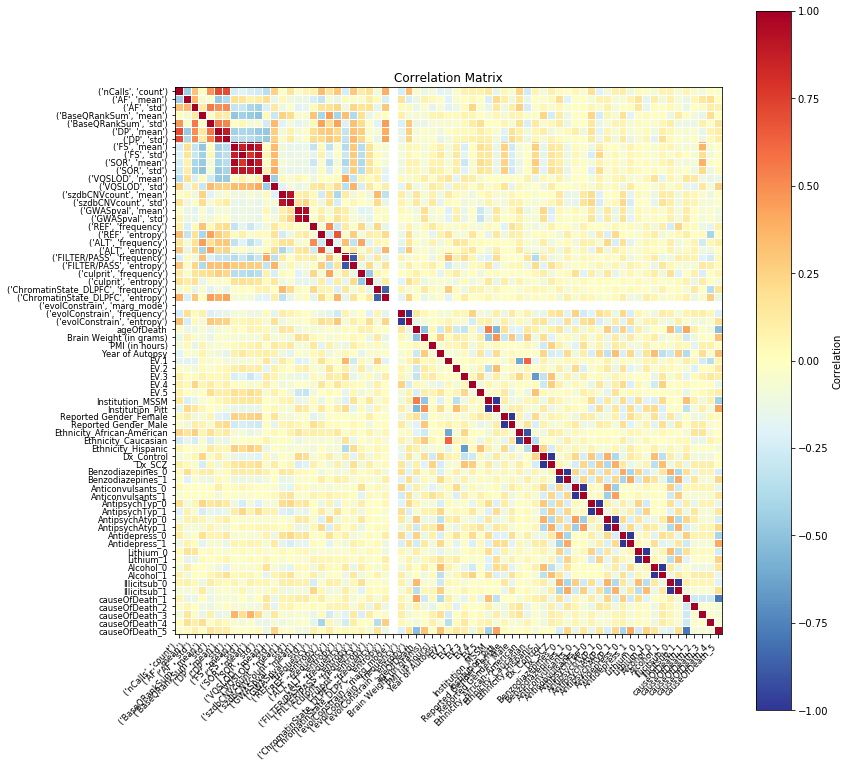

In [6]:
datanum = preprocessing.dummify_df(data)
def corrmatplot(dfnum):
    corrmat = dfnum.corr()
    fig, ax = plt.subplots(figsize=(12,12))
    sm.graphics.plot_corr(corrmat, ax=ax, xnames=corrmat.columns, ynames=corrmat.columns)
    cb = plt.colorbar(ax.get_images()[0])
    cb.set_label('Correlation')
    return((fig, ax))
corrmatplot(datanum)

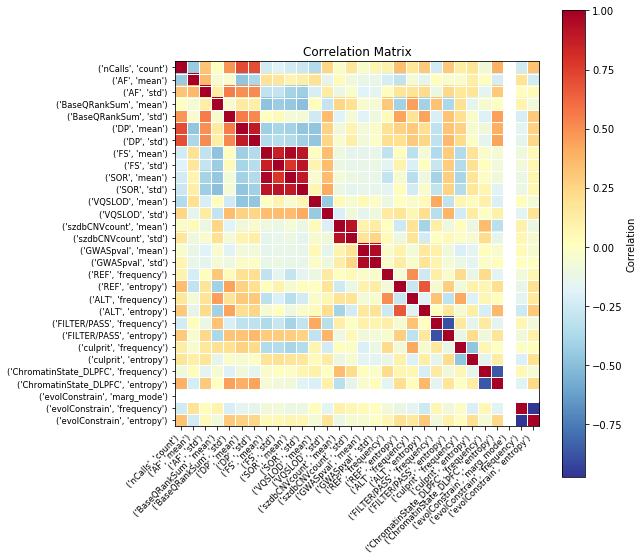

In [7]:
fig, ax = corrmatplot(datanum.loc[:, :('evolConstrain', 'entropy')])
fig.set_size_inches(8, 8)

In [8]:
collinear_cols = ['DP_std', 'FS_std', 'SOR_mean', 'SOR_std', 'szdbCNVcount_std', 'GWASpval_std']

## Modeling: Dx as response

First let's preprocess the data

In [9]:
def preprocess_filter(data, c2d=collinear_cols):
    data1 = preprocessing.preprocess(data)
    # we remove the marginal modes since these are all degenerate variables
    cols2drop = [y for y in data1.columns if re.match('.*_marg_mode', y)]
    data1 = data1.drop(columns=cols2drop + c2d)
    return(data1)

data1 = preprocess_filter(data, c2d=[]) # we omit the removing of collinear_cols

### Forward variable selection

In [10]:
best1 = fwsel.forward_selected(data1, 'Dx')

In [11]:
best1.model.formula

'Dx ~ AntipsychAtyp + YearofAutopsy + AntipsychTyp + EV3 + Institution + Benzodiazepines + causeOfDeath + Ethnicity + FILTERPASS_entropy + REF_entropy + BrainWeightingrams + EV4 + BaseQRankSum_mean + Antidepress + REF_frequency + ChromatinState_DLPFC_frequency + FILTERPASS_frequency + ALT_frequency + DP_std + SOR_std + VQSLOD_std + ReportedGender + evolConstrain_entropy + evolConstrain_frequency + 1'

In [12]:
best1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     9.333
Date:                Thu, 10 Sep 2020   Prob (F-statistic):           9.27e-13
Time:                        11:42:28   Log-Likelihood:                 19.826
No. Observations:                  86   AIC:                             18.35
Df Residuals:                      57   BIC:                             89.52
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.5297      0.100      5.290      0.000       0.329       0.730
AntipsychAtyp[T.1]                 0.5393      0.068      7.914      0.000       0.403       0.676
AntipsychTyp[T.1]                  0.3237      0.089      3.638      0.001       0.146       0.502
Institution[T.Pitt]                0.0263      0.093      0.283      0.778      -0.160       0.212
Benzodiazepines[T.1]              -0.0735      0.094     -0.783      0.437      -0.261       0.115
causeOfDeath[T.2]                  0.2723      0.193      1.409      0.164      -0.115       0.660
causeOfDeath[T.3]                  0.4068      0.209      1.948      0.056      -0.011       0.825
causeOfDeath[T.4]                  0.0376      0.242      0.155      0.877      -0.447       0.522
causeOfDeath[T.5]                  0.1420      0.099      1.432      0.158      -0.057       0.341
Ethnicity[T.Caucasian]             0.0433      0.090      0.483      0.631      -0.136       0.223
Ethnicity[T.Hispanic]             -0.4821      0.306     -1.578      0.120      -1.094       0.130
Antidepress[T.1]                  -0.1747      0.092     -1.908      0.061      -0.358       0.009
ReportedGender[T.Male]            -0.1104      0.069     -1.604      0.114      -0.248       0.027
YearofAutopsy                     -0.1778      0.034     -5.185      0.000      -0.246      -0.109
EV3                                0.0770      0.038      2.017      0.048       0.001       0.153
FILTERPASS_entropy                 0.1761      0.073      2.426      0.018       0.031       0.321
REF_entropy                       -0.1623      0.043     -3.738      0.000      -0.249      -0.075
BrainWeightingrams                -0.1147      0.038     -3.010      0.004      -0.191      -0.038
EV4                                0.0388      0.031      1.268      0.210      -0.022       0.100
BaseQRankSum_mean                 -0.1010      0.043     -2.348      0.022      -0.187      -0.015
REF_frequency                      0.1006      0.037      2.752      0.008       0.027       0.174
ChromatinState_DLPFC_frequency    -0.0258      0.032     -0.815      0.418      -0.089       0.038
FILTERPASS_frequency               0.1802      0.081      2.222      0.030       0.018       0.343
ALT_frequency                     -0.0950      0.044     -2.151      0.036      -0.183      -0.007
DP_std                             0.1847      0.055      3.376      0.001       0.075       0.294
SOR_std                            0.1347      0.051      2.631      0.011       0.032       0.237
VQSLOD_std                        -0.0835      0.038     -2.172      0.034      -0.161      -0.007
evolConstrain_entropy             -0.2251      0.150     -1.504      0.138      -0.525       0.075
evolConstrain_

## Simple univariate regression

Fitting logit
Optimization terminated successfully.
         Current function value: 0.558083
         Iterations 7
Fitting probit
Optimization terminated successfully.
         Current function value: 0.557065
         Iterations 6


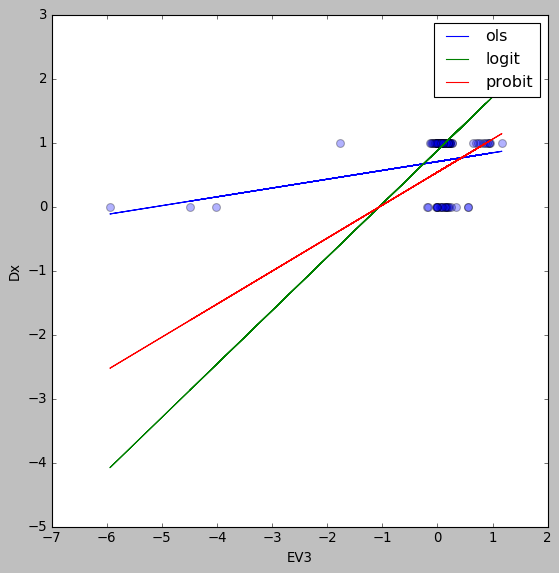

In [13]:
%matplotlib inline
plt.style.use('classic')

def simple_reg(sel_col='EV3', data=data1):
    f = 'Dx ~ ' + sel_col
    lin = smf.ols(formula=f, data=data1).fit()
    print('Fitting logit')
    logi = smf.logit(formula=f, data=data1).fit()
    print('Fitting probit')
    probi = smf.probit(formula=f, data=data1).fit()
    #p = sm.graphics.plot_regress_exog(lin, sel_col)
    fig, ax = plt.subplots(figsize=(8, 8))
    data.plot(x=sel_col, y='Dx', kind='scatter', alpha=0.3, s=50, marker='o', ax=ax)
    ax.plot(data[sel_col].values, lin.fittedvalues.values, label='ols')
    ax.plot(data[sel_col].values, logi.fittedvalues.values, label='logit')
    ax.plot(data[sel_col].values, probi.fittedvalues.values, label='probit')
    ax.legend()
    return((lin, logi, probi))

mm = simple_reg('EV3')

Fitting logit
Optimization terminated successfully.
         Current function value: 0.599428
         Iterations 5
Fitting probit
Optimization terminated successfully.
         Current function value: 0.599299
         Iterations 5


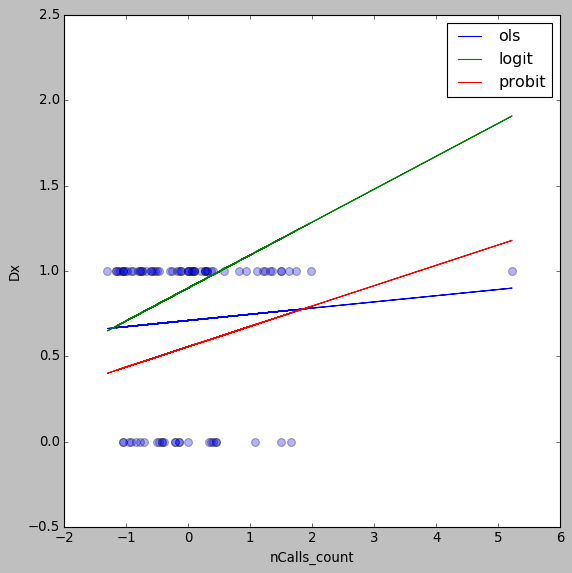

In [14]:
mm = simple_reg('nCalls_count', data=data1)

## Modeling: nCalls as response

The idea is to use the nCalls variable as response.  Benefits include:
* nCalls is better suited for linear modeling since it can be considered as a continuous response variable
* technical variables that affect nCalls such as read depth (see below) can be incorporated into the model

### Visual exploration

Text(0.5, 0.98, 'no. calls and read depth')

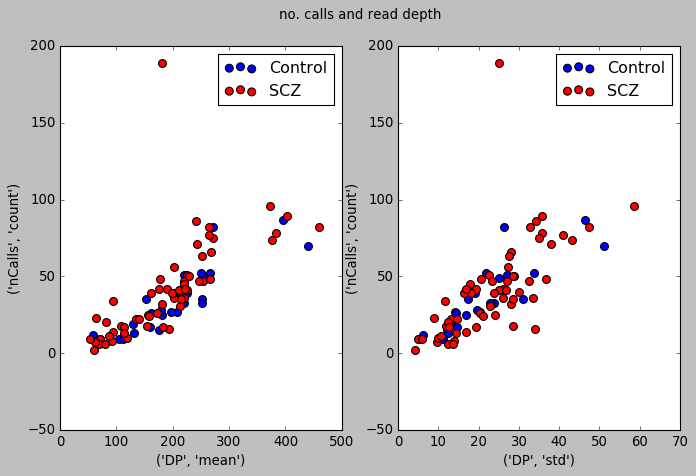

In [15]:
def myscatter(ax, x=('DP', 'mean'), y=('nCalls', 'count')):
    df = data.loc[data['Dx'] == 'Control', [x, y]]
    ax.scatter(x=df[x], y=df[y], label='Control', c='b', s=50)
    df = data.loc[data['Dx'] == 'SCZ', [x, y]]
    ax.scatter(x=df[x], y=df[y], label='SCZ', c='r', s=50)
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.legend()
    return(None)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
myscatter(ax=ax[0], x=('DP', 'mean'), y=('nCalls', 'count'))
myscatter(ax=ax[1], x=('DP', 'std'), y=('nCalls', 'count'))
fig.suptitle('no. calls and read depth')

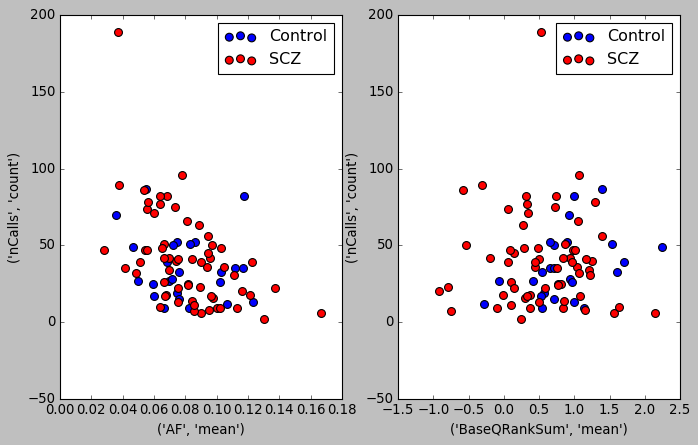

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
myscatter(ax=ax[0], x=('AF', 'mean'), y=('nCalls', 'count'))
myscatter(ax=ax[1], x=('BaseQRankSum', 'mean'), y=('nCalls', 'count'))

### Finding the outlier

In [17]:
data[('nCalls', 'count')].sort_values()

CMC_MSSM_201      2
CMC_MSSM_266      6
CMC_MSSM_331      6
CMC_MSSM_293      7
CMC_MSSM_308      8
               ... 
CMC_MSSM_343     86
CMC_MSSM_406     87
CMC_MSSM_213     89
CMC_MSSM_097     96
CMC_MSSM_224    189
Name: (nCalls, count), Length: 86, dtype: int64

In [18]:
clin.loc['CMC_MSSM_224']

Institution                            MSSM
Reported Gender                      Female
Ethnicity                  African-American
ageOfDeath                               53
Brain Weight (in grams)                1130
PMI (in hours)                          6.3
Dx                                      SCZ
Year of Autopsy                        2001
Benzodiazepines                           0
Anticonvulsants                           0
AntipsychTyp                              0
AntipsychAtyp                             1
Antidepress                               0
Lithium                                   0
Alcohol                                   0
Illicitsub                                0
causeOfDeath                              1
EV.1                              -0.080551
EV.2                               0.000982
EV.3                               0.035962
EV.4                               0.000456
EV.5                               0.006669
Name: CMC_MSSM_224, dtype: objec

### Forward variables selection

In [19]:
best1 = fwsel.forward_selected(data1, 'nCalls_count')

In [20]:
best1.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + DP_std + AF_mean + Ethnicity + AntipsychAtyp + YearofAutopsy + Anticonvulsants + REF_entropy + szdbCNVcount_std + EV1 + evolConstrain_frequency + Lithium + Antidepress + BrainWeightingrams + GWASpval_mean + GWASpval_std + EV2 + 1'

In [21]:
best1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nCalls_count   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     10.63
Date:                Thu, 10 Sep 2020   Prob (F-statistic):           1.25e-13
Time:                        11:42:48   Log-Likelihood:                -59.094
No. Observations:                  86   AIC:                             160.2
Df Residuals:                      65   BIC:                             211.7
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7650      0.258      2.965      0.004       0.250       1.280
ReportedGender[T.Male]     -0.4034      0.154     -2.627      0.011      -0.710      -0.097
Ethnicity[T.Caucasian]     -0.5628      0.267     -2.111      0.039      -1.095      -0.030
Ethnicity[T.Hispanic]      -0.6869      0.441     -1.557      0.124      -1.568       0.194
AntipsychAtyp[T.1]          0.3810      0.169      2.259      0.027       0.044       0.718
Anticonvulsants[T.1]       -0.6174      0.243     -2.539      0.014      -1.103      -0.132
Lithium[T.1]               -0.6970      0.599     -1.164      0.249      -1.893       0.499
Antidepress[T.1]           -0.2762      0.178     -1.550      0.126      -0.632       0.080
DP_mean                     0.2066      0.149      1.382      0.172      -0.092       0.505
culprit_entropy             0.1483      0.066      2.237      0.029       0.016       0.281
DP_std                      0.3451      0.150      2.306      0.024       0.046       0.644
AF_mean                    -0.2515      0.080     -3.155      0.002      -0.411      -0.092
YearofAutopsy              -0.1175      0.070     -1.688      0.096      -0.257       0.022
REF_entropy                 0.1020      0.078      1.311      0.195      -0.053       0.257
szdbCNVcount_std            0.0669      0.073      0.920      0.361      -0.078       0.212
EV1                        -0.0885      0.089     -0.992      0.325      -0.266       0.090
evolConstrain_frequency    -0.0894      0.071     -1.254      0.214      -0.232       0.053
BrainWeightingrams          0.1316      0.077      1.699      0.094      -0.023       0.286
GWASpval_mean              -0.6319      0.239     -2.648      0.010      -1.109      -0.155
GWASpval_std                0.5781      0.241      2.400      0.019       0.097       1.059
EV2                        -0.0813      0.065     -1.254      0.214      -0.211       0.048
==============================================================================
Omnibus:                       61.475   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              439.745
Skew:                           2.061   Prob(JB):                     3.24e-96
Kurtosis:                      13.282   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Remove redundant (collinear) columns

In [22]:
data2 = preprocess_filter(data, c2d=collinear_cols) # we remove collinear_cols
best2 = fwsel.forward_selected(data2, 'nCalls_count')

In [23]:
best2.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + AF_mean + Ethnicity + YearofAutopsy + AntipsychAtyp + BaseQRankSum_std + EV1 + szdbCNVcount_mean + REF_entropy + Anticonvulsants + evolConstrain_frequency + Antidepress + 1'

Selected variables in `best1.model` that persisted in `best2.model`:

In [24]:
set(best2.model.exog_names).intersection(set(best1.model.exog_names))

{'AF_mean',
 'Anticonvulsants[T.1]',
 'Antidepress[T.1]',
 'AntipsychAtyp[T.1]',
 'DP_mean',
 'EV1',
 'Ethnicity[T.Caucasian]',
 'Ethnicity[T.Hispanic]',
 'Intercept',
 'REF_entropy',
 'ReportedGender[T.Male]',
 'YearofAutopsy',
 'culprit_entropy',
 'evolConstrain_frequency'}

Selected variables in `best2.model` that weren't selected in `best1.model`:

In [25]:
set(best2.model.exog_names) - set(best1.model.exog_names)

{'BaseQRankSum_std', 'szdbCNVcount_mean'}

Previously selected variables that dropped out in `best2.model`:

In [26]:
set(best1.model.exog_names) - set(best2.model.exog_names)

{'BrainWeightingrams',
 'DP_std',
 'EV2',
 'GWASpval_mean',
 'GWASpval_std',
 'Lithium[T.1]',
 'szdbCNVcount_std'}

## Transcription start sites hypothesis

The above analysis did not suggest involvement of chromatin state in somatic risk variants for schizophrenia.  However, our previous descriptive statistical analysis (2020-06-10-annotate-explore-variants)showed tendency for the enrichment of transcription start sites (TssA and TssAFlnk) in SCZ somatic variants relative to Control.  Why is this discrepancy?

The discrepancy might have arisen because the `ChromatinState_DLPFC` factor has 15 levels thus increases the degrees of freedom by quite a lot (14 to be precise) in regression models.  Here I test this hypothesis by merging the 15 levels into only two levels: one containing TssA and TssAFlnk while the other all the other 13 chromatin states.

In [27]:
calls_tss = calls.copy()
s = calls['ChromatinState_DLPFC']
d = {'TssA': ['TssA', 'TssAFlnk'],  'Other': ['TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts', 'Het', 'TssBiv', 'ReprPC', 'ReprPCWk', 'Quies']} 
calls_tss['ChromatinState_DLPFC'] = preprocessing.collapse_categories(s, d)

In [28]:
aggcalls_tss = individuals.agg_calls(calls_tss)
data_tss = pd.concat([aggcalls_tss, clin], axis=1)
data2_tss = preprocess_filter(data_tss, c2d=collinear_cols) # we remove collinear_cols

In [29]:
best2_tss = fwsel.forward_selected(data2_tss, 'nCalls_count')

In [30]:
best2_tss.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + AF_mean + Ethnicity + ChromatinState_DLPFC_entropy + ChromatinState_DLPFC_frequency + EV1 + YearofAutopsy + AntipsychAtyp + Institution + Anticonvulsants + BrainWeightingrams + AF_std + Illicitsub + ageOfDeath + szdbCNVcount_mean + 1'

Selected variables in `best2.model` that persisted in `best2_tss.model`:

In [31]:
set(best2_tss.model.exog_names).intersection(set(best2.model.exog_names))

{'AF_mean',
 'Anticonvulsants[T.1]',
 'AntipsychAtyp[T.1]',
 'DP_mean',
 'EV1',
 'Ethnicity[T.Caucasian]',
 'Ethnicity[T.Hispanic]',
 'Intercept',
 'ReportedGender[T.Male]',
 'YearofAutopsy',
 'culprit_entropy',
 'szdbCNVcount_mean'}

Selected variables in `best2_tss.model` that weren't selected in `best2.model`:

In [32]:
set(best2_tss.model.exog_names) - set(best2.model.exog_names)

{'AF_std',
 'BrainWeightingrams',
 'ChromatinState_DLPFC_entropy',
 'ChromatinState_DLPFC_frequency',
 'Illicitsub[T.1]',
 'Institution[T.Pitt]',
 'ageOfDeath'}

Previously selected variables in `best2.model` that dropped out in `best2_tss.model`:

In [33]:
set(best2.model.exog_names) - set(best2_tss.model.exog_names)

{'Antidepress[T.1]',
 'BaseQRankSum_std',
 'REF_entropy',
 'evolConstrain_frequency'}

In [34]:
%connect_info

{
  "shell_port": 52125,
  "iopub_port": 51407,
  "stdin_port": 43331,
  "control_port": 49209,
  "hb_port": 54979,
  "ip": "127.0.0.1",
  "key": "b76669ed-f0142cd06f2426637659aa81",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-dbb91032-b8c8-4f79-95a0-506769192346.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
